<a href="https://colab.research.google.com/github/SPThole/DL-Projects/blob/master/NER_BERT/BERT_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing/ Importing required libraries

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm_notebook as tqdm

import transformers
from transformers import BertForTokenClassification, AdamW,BertModel
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

# Data

In [5]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

In [6]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/entity-annotated-corpus.zip', 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive")

In [7]:
# !pip install transformers

In [8]:
df = pd.read_csv('/content/drive/MyDrive/ner.csv', encoding = "ISO-8859-1", error_bad_lines=False)
df1 = pd.read_csv('/content/drive/MyDrive/ner_dataset.csv', encoding = "ISO-8859-1", error_bad_lines=False)

# df1 = df1.loc[:1000]

In [9]:
df1['Sentence #'] = df1['Sentence #'].fillna(method = 'ffill')
Label_encoder = LabelEncoder()
df1["Tag"] = Label_encoder.fit_transform(df1["Tag"])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


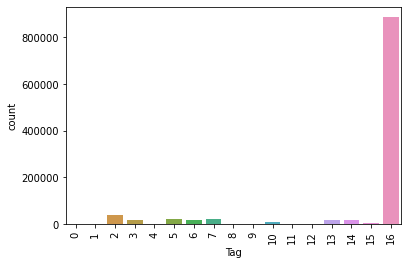

In [10]:
sns.countplot(df1['Tag'])
plt.xticks(rotation=90)
plt.show()

In [11]:
sentences = list(df1.groupby("Sentence #")["Word"].apply(list).reset_index()['Word'].values)
vals = list(df1.groupby("Sentence #")["Tag"].apply(list).reset_index()['Tag'].values)
sentences = [" ".join(s) for s in sentences]

In [12]:
# from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence
tokenizer = transformers.BertTokenizer.from_pretrained(
        'bert-base-cased',
        do_lower_case=True
    )

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [13]:
# df1['Tag'] = df1['Tag'] + 1

In [14]:
class ner_dataset(Dataset):

  def __init__(self,sentences,vals,tokenizer,max_len):
    self.sentences = sentences
    self.vals = vals
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __getitem__(self,idx):

    s = self.sentences[idx].split(" ")
    v = self.vals[idx]
    d = {'input_ids':[],'attention_mask':[],'labels':[]}
    text = []
    labels = []
    mask = []
    for w in range(len(s)) :
      i, l = self.align_labels(self.tokenizer,s[w],v[w])
      text.extend(i['input_ids'])
      labels.extend(l)
      mask.extend(i['attention_mask'])
    d['input_ids'] = [101] + self.pad(text+ [102],self.max_len)
    d['labels'] = [0] + self.pad(labels+ [0],self.max_len)
    d['attention_mask'] = [1] + self.pad(mask+ [1],self.max_len)

    d['input_ids'] = torch.tensor(d['input_ids'])
    d['labels'] = torch.tensor(d['labels'])
    d['attention_mask'] = torch.tensor(d['attention_mask'])

    return d

  def __len__(self):
    return len(self.sentences)

  def align_labels(self,tokenizer,word,label):
    word = tokenizer(word,add_special_tokens=False)
    labels = []
    for i in range(len(word['input_ids'])):
      labels.append(label)
    return word,labels

  def pad(self,s,max_len):
    pad_len = max_len - len(s)
    if pad_len>0:
      for i in range(pad_len):
        s.append(0)
    return s[:max_len-1]









In [15]:
dataset = ner_dataset(sentences,vals,tokenizer,100)

In [16]:
train_dataset, test_dataset = random_split(dataset,[int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])

In [17]:
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=False)
test_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=False)

In [18]:
dataset[1]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'input_ids': tensor([  101,   178, 23851,  1389,  3878,  1474,  1152,  5363,  1106,  1243,
          2469,  1106, 10410,  7246,  2192,  1104,  1103,  2582, 26055,  3965,
          6194,   117,  1170,  1126,   178,  5024,  1161, 10900,  1449,  3471,
         12641,   119,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     

# Model

In [19]:
class ner_model(nn.Module):
  def __init__(self,num_class):
    super(ner_model,self).__init__()
    self.num_class = num_class
    self.bert = transformers.BertModel.from_pretrained(
            "bert-base-uncased"
        )
    self.logit = nn.Linear(768,self.num_class)
    
  def forward(self,ids,mask):
     x = self.bert(ids, 
            attention_mask=mask)
     x = self.logit(x['last_hidden_state'])
     return x
            
    
    
        


In [20]:
model = ner_model(df1['Tag'].nunique())
num_class = df1['Tag'].nunique()
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (

In [21]:
# model = TheModelClass(*args, **kwargs)
# model = transformers.BertModel.from_pretrained('/content/drive/MyDrive/ner_model.pth')

In [22]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.0,
    },
]

optimizer = optim.AdamW(optimizer_parameters,lr=1e-5)


loss_fn = nn.CrossEntropyLoss()

In [23]:
def loss_fn1(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


# Training

In [25]:
class train_model:

  def __init__(self, 
               train_loader,
               test_loader,
               task,
               model,
               optimizer,
               criterion,
               epochs,
               ):
    
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.task = task
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = epochs
    self.model = model
    

  

  def train_it(self):
    """
    """
    history = {'train_loss':[],
                 'test_loss':[],
                 'train_score':[],
                 'test_score':[]}
    for epoch in range(self.epochs):
      
      model.train()
      for loader in tqdm(self.train_loader):

        self.optimizer.zero_grad()
        d = loader
        ids, msk, ys= d['input_ids'].to(device), d['attention_mask'].to(device), d['labels'].to(device)
        
        
        preds= self.predict(ids,msk)
        # print(preds.shape,ys.shape)
        loss = loss_fn1(preds, ys, msk, num_class)

        loss.backward()
        self.optimizer.step()
        
      model.eval()

      # history['train_loss'].append(self.calc_loss(self.train_loader))
      history['test_loss'].append(self.calc_loss(self.test_loader))
      # history['train_score'].append(self.calc_score(self.train_loader))
      # history['test_score'].append(self.calc_score(self.test_loader))

      if epoch%1==0:
        print(f"Iteration : {epoch}")
        torch.save(model.state_dict(), '/content/drive/MyDrive/model_ner2.pth')
        
        fig = plt.figure(figsize = (12,7))
        plt.subplot(1, 2, 1)
        # plt.plot(history['train_loss'], color = 'red', label = 'Training Loss')
        plt.plot(history['test_loss'], color = 'green', label = 'Validation Loss')
        plt.legend()
        

        # plt.subplot(1, 2, 2)
        # plt.plot(history['train_score'], color = 'red', label = 'Training Score')
        # plt.plot(history['test_score'], color = 'green', label = 'Validation Score' )
        # plt.legend()
        plt.show()
        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection = '3d')
        # ax.scatter(X[:,0], X[:,1], model(torch.tensor(X).float())[:,0].detach().numpy())
        # plt.show()
    return self.model, history

  def r2(self, xs, ys):
    return r2_score(ys.reshape(-1,), self.predict(xs).numpy())
 
  def acc(self, ys, preds):
    maxs, cls = torch.max(preds, axis = 1)
    
    return torch.sum(cls==ys.reshape(-1,)).item()/ys.shape[0]

  def predict(self,xs,msk):
    return self.model(xs,msk)

  def calc_loss(self,loader):
    loss = []
    for idx, data in enumerate(loader):
      ids, msk, ys= data['input_ids'].to(device), data['attention_mask'].to(device), data['labels'].to(device)
      preds,msk,ys = self.predict(ids,msk).reshape(-1,num_class).detach().cpu(),data['attention_mask'].detach().cpu(),ys.detach().cpu()
      loss.append(loss_fn1(preds, ys, msk, num_class).item())
    return sum(loss)/len(loss)

  def calc_score(self,loader):
    scores = []
    for data in loader:
      ids, msk, ys= data['input_ids'].to(device), data['attention_mask'].to(device), data['labels'].to(device)
      preds,ys = self.predict(ids,msk).reshape(-1,num_class).detach().cpu(),ys.detach().cpu()
      if self.task == 'reg':
          
          scores.append(self.r2(ys,preds))
          
      else:

        
          scores.append(self.acc(ys,preds))
    return np.mean(scores)

In [26]:
trainer = train_model(train_dataloader,
               test_dataloader,
               'clf',
               model,
               optimizer,
               loss_fn,
               3,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1199 [00:00<?, ?it/s]

Iteration : 0


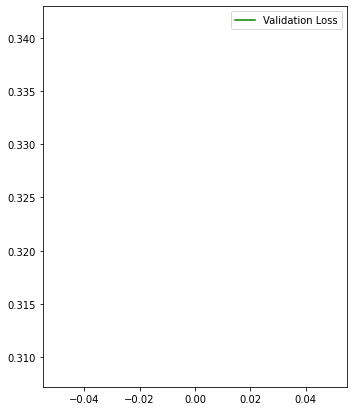

  0%|          | 0/1199 [00:00<?, ?it/s]

Iteration : 1


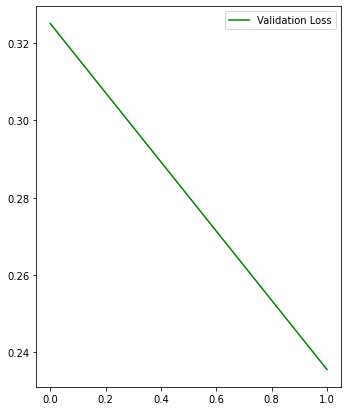

  0%|          | 0/1199 [00:00<?, ?it/s]

Iteration : 2


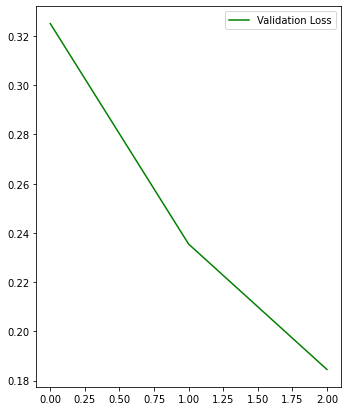

In [27]:
history = trainer.train_it()

# Inference 

In [28]:
test_model = model.to('cpu')
test_model.eval()

ner_model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [33]:
text = """
The Indian central government on Tuesday extended the nationwide Covid-19 containment measures till October 31
"""
def ner_infer(text):
  lent = len(text.split(" "))
  infer_dataset = ner_dataset([text],[[1]*lent],tokenizer,100)
  ids, msk, ys= infer_dataset[0]['input_ids'], infer_dataset[0]['attention_mask'], infer_dataset[0]['labels']
  out = test_model(ids.unsqueeze(0).to('cpu'),msk.unsqueeze(0).to('cpu'))[0]
  out_idx = [torch.argmax(o,dim=-1).item() for o in out]
  pred = [Label_encoder.classes_[i] for i in out_idx]
  infer_dict = {'Word':[],'len_token':[],'preds':[]}
  k,j =1,1
  for i in text.split(' '):
    t = len(tokenizer(i,add_special_tokens=False)['input_ids'])
    k,j = j,j+t
    infer_dict['Word'].append(i)
    infer_dict['len_token'].append(t)
    infer_dict['preds'].append(pred[k:j])
  return pd.DataFrame(infer_dict)

In [34]:
ner_infer(text)

,Word,len_token,preds
0,\nThe,1,[O]
1,Indian,2,"[B-gpe, B-gpe]"
2,central,1,[O]
3,government,1,[O]
4,on,1,[O]
5,Tuesday,3,"[B-tim, B-tim, B-tim]"
6,extended,1,[O]
7,the,1,[O]
8,nationwide,1,[O]
9,Covid-19,4,"[O, O, O, O]"
